# 1. Import and Install Dependencies

In [1]:
# Please install the following ependencies in your conda or python environment:
# tensorflow: For building/training the LSTM model.
# opencv-python (cv2): For real-time video processing.
# mediapipe: To detect body/hand/face landmarks (access the Holistic model for landmark detection).
# scikit-learn: For data splitting and evaluation metrics.
# matplotlib: For plotting (debugging/visualization).
# numpy: For numerical operations on landmark data.
# os: For file/folder operations.
# tensorflowjs: Optional (for exporting the model to JavaScript).

In [102]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import time
import mediapipe as mp

# 2. Keypoints using MP Holistic

In [103]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [104]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [105]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

In [106]:
def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [107]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)

        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

In [108]:
draw_landmarks(frame, results)

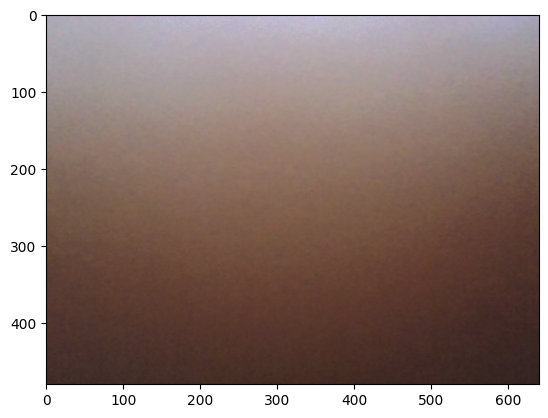

In [109]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

# 3. Extract Keypoint Values

In [110]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

In [111]:
result_test = extract_keypoints(results)

In [112]:
result_test

array([0., 0., 0., ..., 0., 0., 0.])

# 4. Setup Folders for Collection

In [113]:
import os
DATA_PATH = os.path.join('MP_Data')          # Root folder
# actions = np.array(['hello', 'thanks', 'iloveyou'])  # Actions to detect
no_sequences = 30          # Sequences per action
sequence_length = 30        # Frames per sequence

# Read words from file
with open('actions.txt', 'r') as f:
    words = [ line.strip() for line in f  # trim spaces from both ends
        if line.strip()             # ignore empty lines
            ]
# Convert to NumPy array
actions = np.array(words)
print(actions)

# Create folder structure
if not os.path.exists(DATA_PATH):
    os.makedirs(DATA_PATH)
    for action in actions:
        for sequence in range(no_sequences):
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)), exist_ok=True)

['baby' 'cat' 'father' 'friend' 'good' 'happy' 'house' 'love' 'me' 'mean'
 'meet' 'no' 'sad' 'thanks' 'think' 'worry']


# 5. Collect Keypoint Values for Training and Testing

In [66]:
cap = cv2.VideoCapture(0)
stop = False
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    # NEW LOOP
    # Loop through actions
    for action in actions:
        # Loop through sequences aka videos
        for sequence in range(no_sequences):
            # Loop through video length aka sequence length
            for frame_num in range(sequence_length):

                # Read feed
                ret, frame = cap.read()

                # Make detections
                image, results = mediapipe_detection(frame, holistic)

                # Draw landmarks
                draw_styled_landmarks(image, results)
                
                # NEW Apply wait logic
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(500)
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                
                # NEW Export keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), 'frame_{}'.format(frame_num))
                np.save(npy_path, keypoints)

                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    stop = True
                    break
            if stop:
                break
        if stop:
            break
                    
    cap.release()
    cv2.destroyAllWindows()

In [114]:
cap.release()
cv2.destroyAllWindows()

# 6. Preprocess Data and Create Labels and Features

In [115]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [116]:
label_map = {label:num for num, label in enumerate(actions)}

In [117]:
label_map

{'baby': 0,
 'cat': 1,
 'father': 2,
 'friend': 3,
 'good': 4,
 'happy': 5,
 'house': 6,
 'love': 7,
 'me': 8,
 'mean': 9,
 'meet': 10,
 'no': 11,
 'sad': 12,
 'thanks': 13,
 'think': 14,
 'worry': 15}

In [118]:
sequences, labels = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "frame_{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [119]:
np.array(sequences).shape

(480, 30, 1662)

In [120]:
np.array(labels).shape

(480,)

In [121]:
X = np.array(sequences)

In [122]:
X.shape

(480, 30, 1662)

In [123]:
y = to_categorical(labels).astype(int)

In [124]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

In [125]:
y_test.shape

(24, 16)

# 7. Build and Train LSTM Neural Network

In [126]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [127]:
# Per-Class Accuracy:
# Now explicitly calculated and logged for each action (cat_acc, food_acc, help_acc)
# Appears in both TensorBoard and the training logs
# Better Organization:
# Separate TensorBoard writers for metrics vs. confusion matrices
# Timestamped directories to avoid overwriting
# Visual Enhancements:
# Clearer confusion matrix with percentages
# Larger fonts and better spacing
    
from tensorflow.keras.callbacks import Callback
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from datetime import datetime
from sklearn.metrics import confusion_matrix

class AdvancedMetrics(Callback):
    def __init__(self, validation_data, actions):
        super().__init__()
        self.validation_data = validation_data  # (X_test, y_test)
        self.actions = actions
        # Create separate writers for organization
        self.cm_writer = tf.summary.create_file_writer(f'Logs/cm/{datetime.now().strftime("%Y%m%d-%H%M%S")}')
        self.metrics_writer = tf.summary.create_file_writer(f'Logs/metrics/{datetime.now().strftime("%Y%m%d-%H%M%S")}')
        
    def on_epoch_end(self, epoch, logs=None):
        X_val, y_val = self.validation_data
        y_pred = self.model.predict(X_val, verbose=0)
        y_true = np.argmax(y_val, axis=1)
        y_pred_classes = np.argmax(y_pred, axis=1)
        
        # 1. PER-CLASS ACCURACY (Key addition!)
        per_class_acc = {}
        for i, action in enumerate(self.actions):
            mask = y_true == i
            if np.sum(mask) > 0:  # Avoid division by zero
                acc = np.mean(y_pred_classes[mask] == i)
                per_class_acc[f'{action}_acc'] = acc
                logs[f'{action}_acc'] = acc  # Add to standard logs
        
        # 2. CONFUSION MATRIX
        cm = confusion_matrix(y_true, y_pred_classes)
        self._log_confusion_matrix(cm, epoch)
        
        # 3. THRESHOLD-BASED METRICS
        threshold = 0.9
        high_conf_mask = np.max(y_pred, axis=1) > threshold
        if np.any(high_conf_mask):
            high_conf_acc = np.mean(y_pred_classes[high_conf_mask] == y_true[high_conf_mask])
            logs['high_conf_acc'] = high_conf_acc
        
        # Log all custom metrics properly
        with self.metrics_writer.as_default():
            for name, value in per_class_acc.items():
                tf.summary.scalar(name, value, step=epoch)
            if 'high_conf_acc' in logs:
                tf.summary.scalar('high_conf_acc', logs['high_conf_acc'], step=epoch)
    
    def _log_confusion_matrix(self, cm, epoch):
        cm_image = self._plot_cm_to_image(cm)
        with self.cm_writer.as_default():
            tf.summary.image("Confusion Matrix", cm_image, step=epoch)
    
    def _plot_cm_to_image(self, cm):
        fig = plt.figure(figsize=(10, 10), dpi=100)
        plt.imshow(cm, interpolation='nearest', cmap='Blues')
        plt.title("Confusion Matrix", fontsize=12)
        plt.colorbar()
        tick_marks = np.arange(len(self.actions))
        plt.xticks(tick_marks, self.actions, rotation=45, fontsize=10)
        plt.yticks(tick_marks, self.actions, fontsize=10)
        
        # Add text annotations
        thresh = cm.max() / 2.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                plt.text(j, i, format(cm[i, j], 'd'),
                        ha="center", va="center",
                        color="white" if cm[i, j] > thresh else "black")
        
        plt.tight_layout()
        fig.canvas.draw()
        # image = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8)
        # image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        image = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8)
        image = image.reshape(fig.canvas.get_width_height()[::-1] + (4,))
        image = image[..., :3]  # drop alpha channel (RGBA -> RGB)
        plt.close(fig)
        return image[np.newaxis, ...]

In [128]:
# log_dir = os.path.join('Logs')
# tb_callback = TensorBoard(log_dir=log_dir)

log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)
advanced_metrics = AdvancedMetrics(validation_data=(X_test, y_test), actions=actions  )

In [129]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [130]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [35]:
# model.fit(X_train, y_train, epochs=2000, callbacks=[tb_callback])
model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=250,
    callbacks=[tb_callback, advanced_metrics]  # Now includes all features
)

Epoch 1/250


15/15 [==============================] - 17s 409ms/step - loss: 4.0482 - categorical_accuracy: 0.0811 - val_loss: 3.2509 - val_categorical_accuracy: 0.0833 - cat_acc: 1.0000 - father_acc: 0.0000e+00 - good_acc: 0.0000e+00 - happy_acc: 0.0000e+00 - house_acc: 0.0000e+00 - love_acc: 0.0000e+00 - me_acc: 0.0000e+00 - meet_acc: 0.0000e+00 - no_acc: 0.0000e+00 - sad_acc: 0.0000e+00 - thanks_acc: 0.0000e+00 - think_acc: 0.0000e+00
Epoch 2/250
15/15 [==============================] - 3s 206ms/step - loss: 2.9130 - categorical_accuracy: 0.0570 - val_loss: 2.7491 - val_categorical_accuracy: 0.0833 - cat_acc: 0.0000e+00 - father_acc: 0.0000e+00 - good_acc: 0.0000e+00 - happy_acc: 0.0000e+00 - house_acc: 0.0000e+00 - love_acc: 0.0000e+00 - me_acc: 0.0000e+00 - meet_acc: 0.0000e+00 - no_acc: 0.0000e+00 - sad_acc: 0.0000e+00 - thanks_acc: 1.0000 - think_acc: 0.0000e+00
Epoch 3/250
15/15 [==============================] - 3s 206ms/step - loss: 2.7522 - categorical_accuracy: 0.0680 - va

In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 64)            442112    
                                                                 
 lstm_1 (LSTM)               (None, 30, 128)           98816     
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
Total params: 597104 (2.28 MB)
Trainable params: 597104 

# 8. Make Predictions

In [37]:
res = model.predict(X_test)

1/1 [==============================] - 0s 108ms/step


In [38]:
actions[np.argmax(res[4])]

'cat'

In [39]:
actions[np.argmax(y_test[4])]

'cat'

# 9. Save Weights

In [40]:
# model.save('action.h5')
model.save('action.keras')

In [131]:
del model

In [132]:
import tensorflow as tf
model = tf.keras.models.load_model('action.keras')

# 10. Evaluation using Confusion Matrix and Accuracy

In [133]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [134]:
yhat = model.predict(X_test)

1/1 [==============================] - 1s 1s/step


In [135]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [136]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[22,  0],
        [ 0,  2]],

       [[23,  1],
        [ 0,  0]],

       [[23,  0],
        [ 0,  1]],

       [[18,  0],
        [ 1,  5]],

       [[21,  0],
        [ 0,  3]],

       [[22,  0],
        [ 0,  2]],

       [[22,  0],
        [ 0,  2]],

       [[23,  0],
        [ 0,  1]],

       [[22,  1],
        [ 0,  1]],

       [[22,  0],
        [ 0,  2]],

       [[23,  0],
        [ 0,  1]],

       [[23,  0],
        [ 0,  1]],

       [[22,  0],
        [ 1,  1]]], dtype=int64)

In [137]:
accuracy_score(ytrue, yhat)

0.9166666666666666

# 11. Test in Real Time

In [138]:
from scipy import stats
import pyttsx3
import random

In [139]:
# colors = [(245,117,16), (117,245,16), (16,117,245)]
# def prob_viz(res, actions, input_frame, colors):
#     output_frame = input_frame.copy()
#     for num, prob in enumerate(res):
#         cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
#         cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
#     return output_frame




# Ensure there are enough colors
def get_colors(n):
    base_colors = [(245,117,16), (117,245,16), (16,117,245)]
    if n <= len(base_colors):
        return base_colors[:n]
    # Add more random colors if needed
    extra_colors = [tuple(random.choices(range(256), k=3)) for _ in range(n - len(base_colors))]
    return base_colors + extra_colors


def prob_viz(res, actions, input_frame):
    # Ensure res and actions have the same length
    min_length = min(len(res), len(actions))
    res = res[:min_length]
    actions = actions[:min_length]
    
    colors = get_colors(len(actions))   
    output_frame = input_frame.copy()
    res = res[0] if len(res.shape) == 2 else res  # Handle both 1D and 2D inputs

    for num, prob in enumerate(res):
        color = colors[num % len(colors)]  # safe indexing
        cv2.rectangle(output_frame, (0, 60 + num * 40), (int(prob * 100), 90 + num * 40), color, -1)
        cv2.putText(output_frame, actions[num], (0, 85 + num * 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

    return output_frame
     
# def prob_viz(res, actions, input_frame):
#     colors = get_colors(len(actions))   
#     output_frame = input_frame.copy()
#     res = res[0] if len(res.shape) == 2 else res  # Handle both 1D and 2D inputs

#     if colors is None:
#         colors = get_colors(len(actions))  # generate if not provided
  
#     for num, prob in enumerate(res):
#         color = colors[num % len(colors)]  # safe indexing
#         cv2.rectangle(output_frame, (0, 60 + num * 40),  (int(prob * 100), 90 + num * 40), colors[num], -1)
#         cv2.putText(output_frame, actions[num], (0, 85 + num * 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

#     return output_frame

def txt_to_speech(action):
    #text to speech
    engine = pyttsx3.init()
    
    # Set slower speed (e.g., 120 words per minute)
    engine.setProperty('rate', 130)  
    
    # Optional: Change voice (if available)
    voices = engine.getProperty('voices')
    engine.setProperty('voice', voices[0].id)  # Select a different voice
    
    engine.say(action)
    engine.runAndWait()

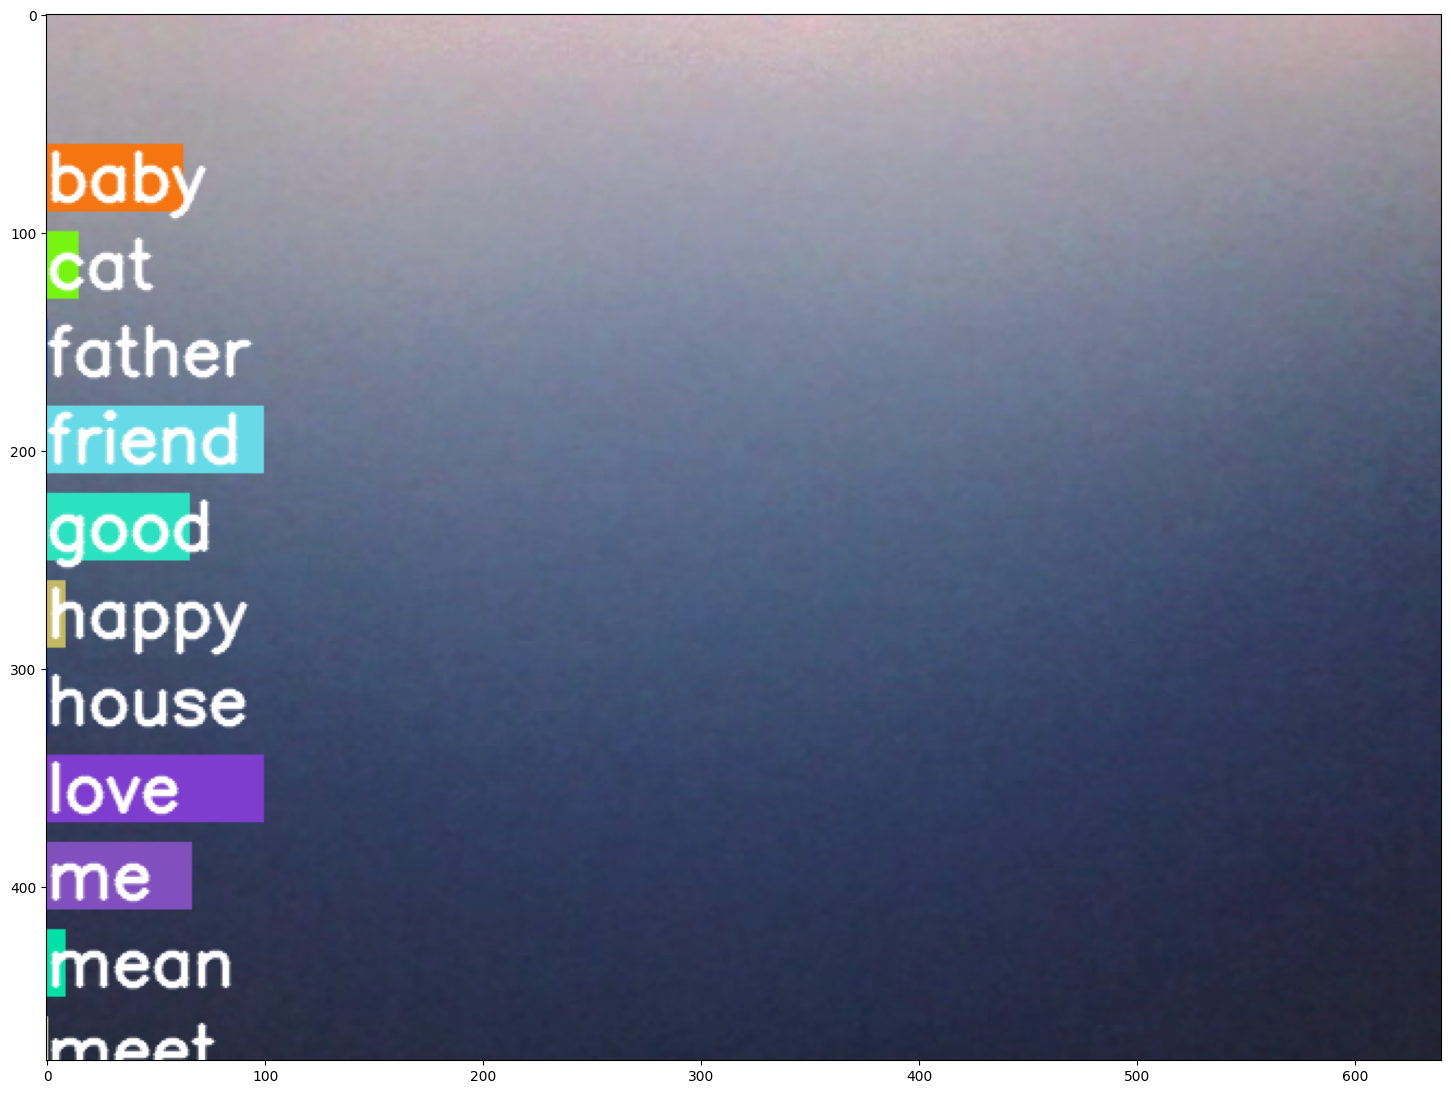

In [140]:
plt.figure(figsize=(18,18))
plt.imshow(prob_viz(res, actions, image))

In [ ]:
# 1. New detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.5


cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
           # txt_to_speech(actions[np.argmax(res)])   #txt to speech
            
        #3. Viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                            txt_to_speech(actions[np.argmax(res)])   #txt to speech
                    else:
                        sentence.append(actions[np.argmax(res)])
                        txt_to_speech(actions[np.argmax(res)])   #txt to speech

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

In [141]:
cap.release()
cv2.destroyAllWindows()